# AI-Generated Image Detection

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
import pandas as pd
import seaborn as sns

import pathlib
from zipfile import ZipFile
import imagehash
import random

2024-03-15 21:26:22.229150: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 21:26:22.229171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 21:26:22.229726: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-15 21:26:22.233025: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-15 21:26:22.754898: W tensorflow/compiler/tf2

### 1.   Importing the Data

- Since the data is in a zip file, It needs to be unzipped to access the images

In [3]:
# Unzip folder
zip_object = ZipFile('datasets/dataset2.zip', 'r')
zip_object.extractall()

-   The data come by default with a training and testing already established

In [4]:
# Storing image data into variables
train_dir = pathlib.Path('train/').with_suffix('')
test_dir = pathlib.Path('test/').with_suffix('')

In [5]:
train_img_array, test_img_array = list(train_dir.glob('*/*')), list(test_dir.glob('*/*'))
total_dataset = train_img_array + test_img_array

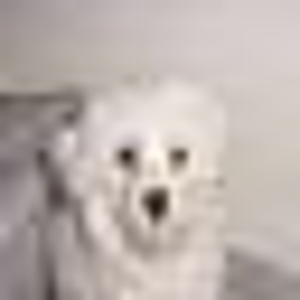

In [6]:
# Display random image in the dataset
random_number = random.randint(0, len(train_img_array))
Image.open(str(train_img_array[random_number])).resize((300, 300))

#### Information about the dataset

In [7]:
# Check the number of items in the dataset
print(f"Training image count : {len(train_img_array)} \nTesting image count : {len(test_img_array)} \nTotal data : {len(total_dataset)}")

Training image count : 100000 
Testing image count : 20000 
Total data : 120000


In [8]:
# Check the number of type image extension in the dataset
image_types = [
    {"file_type": "jpeg", "count": 0},
    {"file_type": "png", "count": 0},
    {"file_type": "jpg", "count": 0},
    {"file_type": "other", "count": 0},
]

# train_image_types = [
#     {"file_type": "jpeg", "count": 0},
#     {"file_type": "png", "count": 0},
#     {"file_type": "jpg", "count": 0},
#     {"file_type": "other", "count": 0},
# ]

# test_image_types = [
#     {"file_type": "jpeg", "count": 0},
#     {"file_type": "png", "count": 0},
#     {"file_type": "jpg", "count": 0},
#     {"file_type": "other", "count": 0},
# ]

def count_filetype(dataset, type_array):
    type_count = len(type_array)
    for c, file_name in enumerate(dataset):
        # Split the file name by the period (.) character
        parts = str(file_name).split(".")
        file_extension = str(parts[-1]).lower() # Get the extension type.
        # print("outer loop : ", c)
        for counter in range(type_count):
            # print("inner loop : ", counter)
            if file_extension == type_array[counter]["file_type"]:
                type_array[counter]["count"]+=1
                break
            if counter == (type_count - 1): # If the loop falls in the "other category"
                type_array[-1]["count"]+=1


# Counts image types occurrence for dataset 
count_filetype(total_dataset, image_types)

# Counts image types occurrence for training set 
# count_filetype(train_img_array, train_image_types)

# Counts image types occurrence for testing set 
# count_filetype(test_img_array, test_image_types)


# Display result for train dataset
for image_type in image_types:
  print(f"Number of {image_type['file_type']} images inside the dataset : {image_type['count']}")
  
# # Display result for train dataset
# for image_type in train_image_types:
#   print(f"Number of {image_type['file_type']} images inside the training dataset : {image_type['count']}")

# print("----------------------------------------------")
# Display result for test dataset
# for image_type in test_image_types:
#   print(f"Number of {image_type['file_type']} images inside the testing dataset : {image_type['count']}")

Number of jpeg images inside the dataset : 0
Number of png images inside the dataset : 0
Number of jpg images inside the dataset : 120000
Number of other images inside the dataset : 0


- We can observe that the dataset only contains jpg images in both the training and testing dataset

### 2.  Data cleaning

#### Check if the dataset contains corrupted and duplicated images.

In [9]:
def clean_image_data(dataset: list):
    # cleaned_images = []
    cleaned_images = 0
    # corrupted_images = []
    corrupted_images = 0
    imgs_shape = []  
    hash_dict = {}
    # duplicate_images = []  
    duplicate_images = 0  
    temp_dataset: list[bool] = [] 

    for count, filename in enumerate(dataset):
        filename = str(filename)
        try:
            with Image.open(filename) as img:
                # Optionally, perform additional checks such as size, format, etc.
                # Check image size
                # if img.size < min_size:
                #     print(f"Ignoring small image: {filename}")
                #     continue
                
                # print("image size : ", img.size)
                
                # img_width.append(img.size[0])
                # img_height.append(img.size[1])
                # Calculate the hash of the image
                img_hash = imagehash.average_hash(img)

                # Check if the hash already exists in the dictionary
                if img_hash in hash_dict:
                    duplicate_images+=1
                    temp_dataset.append(True)
                    # duplicate_images.append([filename, True])
                else:
                    hash_dict[img_hash] = filename
                    temp_dataset.append(False)
                    
                imgs_shape.append(img.size)
                cleaned_images+=1
                # cleaned_images.append(filename)
        except Exception as e:
            # Handle corrupted or unreadable images
            # corrupted_images.append(filename)
            corrupted_images+=1
            print(f"Corrupted image: {filename}, Error: {e}")

    return cleaned_images, corrupted_images, duplicate_images, temp_dataset, imgs_shape
# , img_width, img_height

# data_directory = train_img_array
cleaned_images, corrupted_images, duplicate_images, duplicates_values, imgs_shape = clean_image_data(total_dataset)
# , img_width, img_height = clean_image_data(total_dataset)

print(f"Cleaned images: {cleaned_images}")
print(f"Corrupted images: {corrupted_images}")
print("duplicate images : ", duplicate_images )
print("temp : ", len(duplicates_values) )
# print("duplicate images : ", hash_dict )

Cleaned images: 120000
Corrupted images: 0
duplicate images :  3342
temp :  120000


- We observe that the dataset does not contain any corrupted image
- However duplicates images are in the dataset.

- Duplicated images are based on the image content rather than filenames. 
- The process to find duplicated images is as follows:
    - Turn the image content into a hash value and get the average value of the hash.
    - Compare images hash value and determine if there are duplicate or near-duplicate images based on similarity thresholds.

In [10]:
# Transforming the dataset list into a pandas.Series Dataframe 
df = pd.DataFrame(total_dataset, columns=["Filename"])
shapes = pd.DataFrame(imgs_shape, columns=["width", "height"])
dupl = pd.DataFrame(duplicates_values, columns=["duplicated"])

df = df.merge(shapes, left_index=True, right_index=True)

# merge_df = df.merge(dupl, left_index=True, right_index=True)

In [11]:
# Remove duplicates
print("Before Duplicates :", len(df))

df = df[~dupl["duplicated"]]

print("After removing duplicates :", len(df))

Before Duplicates : 120000
After removing duplicates : 116658


In [12]:
# reset index num 
df.reset_index(drop=True)

,Filename,width,height
0,train/REAL/4053 (9).jpg,32,32
1,train/REAL/2864 (4).jpg,32,32
2,train/REAL/3536 (3).jpg,32,32
3,train/REAL/0183 (8).jpg,32,32
4,train/REAL/1607 (8).jpg,32,32
...,...,...,...
116653,test/FAKE/357 (8).jpg,32,32
116654,test/FAKE/612.jpg,32,32
116655,test/FAKE/603 (9).jpg,32,32
116656,test/FAKE/282.jpg,32,32


In [13]:
# creating new columns to tag data inside the dataset
df["folder_type"] = df["Filename"].apply(lambda x: "Test" if str(x).split("/")[0] == "test" else "Train") 
df["tag"] = df["Filename"].apply(lambda x: "REAL" if str(x).split("/")[1] == "REAL" else "FAKE") 

In [14]:
df.head()

,Filename,width,height,folder_type,tag
0,train/REAL/4053 (9).jpg,32,32,Train,REAL
1,train/REAL/2864 (4).jpg,32,32,Train,REAL
2,train/REAL/3536 (3).jpg,32,32,Train,REAL
3,train/REAL/0183 (8).jpg,32,32,Train,REAL
4,train/REAL/1607 (8).jpg,32,32,Train,REAL


### 3.  Data exploration

In [15]:
# Displays metrics about numerical data
df.describe()

,width,height
count,116658.0,116658.0
mean,32.0,32.0
std,0.0,0.0
min,32.0,32.0
25%,32.0,32.0
50%,32.0,32.0
75%,32.0,32.0
max,32.0,32.0


In [16]:
df.apply(pd.Series.unique)

Filename       [train/REAL/4053 (9).jpg, train/REAL/2864 (4)....
width                                                       [32]
height                                                      [32]
folder_type                                        [Train, Test]
tag                                                 [REAL, FAKE]
dtype: object

- From this data we observe that all the images in the dataset are set in 32x32 pixels

In [17]:
# Displays metrics about non-numerical data
df.describe(include=['object'])

,Filename,folder_type,tag
count,116658,116658,116658
unique,116658,2,2
top,train/REAL/4053 (9).jpg,Train,REAL
freq,1,97536,59123


In [18]:
# Get the number of "REAL" and "FAKE" tags
num_real_tags = df["tag"].apply(lambda x: x.count("REAL")).sum()
num_fake_tags = df["tag"].apply(lambda x: x.count("FAKE")).sum()

num_train_real = df[df["folder_type"] == "Train"]["tag"].apply(lambda x: x.count("REAL")).sum()
num_train_fake = df[df["folder_type"] == "Train"]["tag"].apply(lambda x: x.count("FAKE")).sum()

num_test_real = df[df["folder_type"] == "Test"]["tag"].apply(lambda x: x.count("REAL")).sum()
num_test_fake = df[df["folder_type"] == "Test"]["tag"].apply(lambda x: x.count("FAKE")).sum()

# Get the number of "Train" and "Test" type
num_train = df["folder_type"].apply(lambda x: x.count("Train")).sum()
num_test = df["folder_type"].apply(lambda x: x.count("Test")).sum()

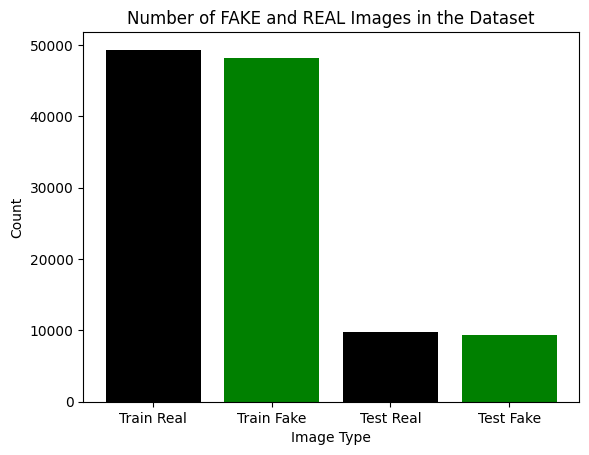

Number of 'FAKE' images: 57535
Number of 'REAL' images: 59123
Difference: 1588


In [19]:
# Create a bar chart
plt.bar(['Train Real', 'Train Fake', "Test Real", "Test Fake"], [num_train_real, num_train_fake, num_test_real, num_test_fake], color=["black", "green"])
plt.xlabel('Image Type')
plt.ylabel('Count')
plt.title('Number of FAKE and REAL Images in the Dataset')
# colors = {'Train Real': ['black', 'green', 'blue']}
# labels = list(colors.keys())
# handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
# plt.legend(handles, labels)
plt.show()
print("Number of 'FAKE' images:", num_fake_tags)
print("Number of 'REAL' images:", num_real_tags)
print("Difference:", num_real_tags - num_fake_tags)

-   from this chart it is noticeable that the difference between REAL and FAKE images is not much

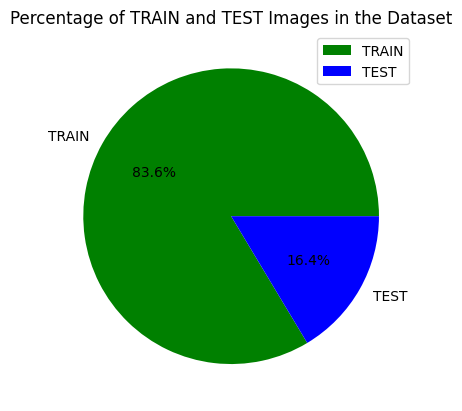

Number of 'Train' images: 97536
Number of 'Test' images: 19122


In [20]:
# Create a piechart

plt.pie([num_train, num_test], labels=["TRAIN", "TEST"], colors=["green", "blue"], autopct='%1.1f%%')
plt.title('Percentage of TRAIN and TEST Images in the Dataset')
plt.legend()
plt.show()
print("Number of 'Train' images:", num_train)
print("Number of 'Test' images:", num_test)

#### Next steps :
-   Investigate if it is needed to handle noisy data in the dataset

### 3. Data preprocessing

In [21]:
# setting up the batch size
batch_size = 32

In [30]:
df.head()

,Filename,width,height,folder_type,tag
0,train/REAL/4053 (9).jpg,32,32,Train,REAL
1,train/REAL/2864 (4).jpg,32,32,Train,REAL
2,train/REAL/3536 (3).jpg,32,32,Train,REAL
3,train/REAL/0183 (8).jpg,32,32,Train,REAL
4,train/REAL/1607 (8).jpg,32,32,Train,REAL


In [161]:
# Function to load and preprocess image
def load_and_preprocess_image(file_path: tf):
    # Load the image
    image = tf.io.read_file(file_path)

    # Decode the image
    image = tf.image.decode_jpeg(image, channels=3)

    # Resize the image
    image = tf.image.resize(image, [32, 32])

    # Normalize the image
    image = image / 255
    
    # print("file path:", type(file_path))

    # Get the label
    label = df[df["Filename"] == file_path]["tag"].values[0]
    # print(label)

    # Return the image and label
    return image, label

In [162]:
# Create a dataset from the list of file paths
dataset = tf.data.Dataset.from_tensor_slices(df["Filename"].astype(str).tolist())

# Load and preprocess the images
dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Split the dataset into training and testing sets to 80:20 ratio
num_train = int(len(df) * 0.8)
num_test = int(len(df) * 0.2)

# Create the training and testing datasets
train_dataset = dataset.shuffle(len(df)).batch(batch_size=batch_size).take(num_train)
test_dataset = dataset.batch(batch_size=batch_size).skip(num_train)

# Create a data generator that yields batches of images and labels
train_data_generator = train_dataset.as_numpy_iterator()
test_data_generator = test_dataset.as_numpy_iterator()

AttributeError: in user code:

    File "/tmp/ipykernel_4597/3753611329.py", line 16, in load_and_preprocess_image  *
        tf.enable_eager_execution()

    AttributeError: module 'tensorflow' has no attribute 'enable_eager_execution'
